<h2 style="background-color:#C2B4B9;color:white;text-align: center;padding-top: 5px;padding-bottom: 5px;border-radius: 5px 5px;"><strong><centre>Methodology: Model Architecture </centre></strong></h2>

#### 03.Model Development
**Objective:** Train a Tradicional RNN model on the preprocessed dataset.

**Model Training:** <br>
<br>
 - **Base Model:**
    + Defines the RNN architecture;
    + Compiles the model with the Adam optimizer and categorical cross-entropy loss;
    + Test adding mores layers to see if the performance gets better
 
 - **Training and Evaluation:**
    + Utilizes EarlyStopping and ModelCheckpoint callbacks for efficient training.
    + Trains the model and evaluates its performance on the validation set.
    + Includes code to visualize training and validation accuracy over epochs.

---

## **Carregamento das Bibliotecas Base**

In [12]:
import os 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import time
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, Dense, Flatten
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.utils import to_categorical


import warnings
warnings.filterwarnings('ignore')

## **Carregamento e Leitura do *Dataset* Pré-processado**

In [13]:
# Definir o caminho do arquivo relativo ao diretório do script
#file_path = os.path.join(os.getcwd(), 'RNN_dataset', 'concatDataset.csv')

base_dir = r'C:\\Users\\maria\\OneDrive - Instituto Superior de Engenharia do Porto\\Desktop\\Semestre\\APROF\\mei-approf\\RNN\\datasets'
file_name = 'preprocessDataset.csv'

file_path = os.path.join(base_dir, file_name)
print(file_path)

C:\\Users\\maria\\OneDrive - Instituto Superior de Engenharia do Porto\\Desktop\\Semestre\\APROF\\mei-approf\\RNN\\datasets\preprocessDataset.csv


+ Utilização do método `read_csv()` para leitura do arquivo CSV com os dados pré-processados

In [14]:
df_motionSense = pd.read_csv(file_path)

+ Visualização das 5 primeiras linhas do *dataset* utilizando o método `head()`

In [15]:
df_motionSense.head(5)

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,category_encoded
0,0.972412,1.112051,0.372160,2.329043,-0.814143,0.190001,0.163109,0.417746,0.891213,0.591696,-0.307112,0.677785,0
1,0.972325,1.157371,0.361670,2.365755,-0.865384,0.187932,0.443882,0.221714,0.524710,0.436217,-0.038492,0.186239,0
2,0.972184,1.184141,0.357830,2.387092,-0.896006,0.186328,-0.080028,-0.036082,0.274351,0.006391,0.082024,-0.342729,0
3,0.965350,1.190361,0.360527,2.390690,-0.903162,0.156397,-0.019555,-0.594680,0.017573,-0.032954,0.084569,0.148985,0
4,0.951164,1.192398,0.358982,2.388570,-0.905503,0.094676,0.054879,-0.519408,0.027154,0.395098,0.349372,-0.111607,0


## **Definição de Variáveis Fixas**

In [16]:
NUM_FEATURES = df_motionSense.shape[1] - 1
NUM_CLASSES = df_motionSense['category_encoded'].nunique()
EPOCHS = 50

**Sequencing Data for Temporal Analysis**

We define a sequence generator function that creates sequences of input features and corresponding target labels from the training and testing data. These sequences have a window length of 150 with a stride of 10. The mode of target labels within each sequence is calculated to represent the label for that sequence. This prepares the data for temporal analysis tasks.

## **Preparação do *Dataset* para treino dos modelos de classificação de atividades baseado em RNN**

+ A função `prepare_data()` realiza o pré-processamento necessário para treinar um modelo de classificação de atividades baseado em RNNs. Este cria sequências de dados a partir da função `create_sequence()` e divide o conjunto de dados em treino e teste.

Esta divisão foi feita com base na função `train_test_split()` do scikit-learn que permite dividir o conjunto de dados em conjuntos de treino e teste. Este separa as *features* ('x_columns') e a *target* ('y_columns') com um tamanho de conjunto de teste de, neste caso, 20% (`test_size=0.2`), garantindo que os comprimentos dos conjuntos de treino para *features* e *targets* sejam os mesmos.

In [17]:
def prepare_data(df, window_length):
    """
    Preprocesses the dataset for training an RNN-based activity classification model.

    Args:
        df (pandas.DataFrame): The input dataset containing features and labels.
        window_length (int): The desired length of the time window for creating sequences.

    Returns:
        X_train, X_test, y_train, y_test: Processed training and testing data.
    """
    def create_sequences(data, target, window_size):
        sequences = []
        targets = []
        for i in range(len(data) - window_size):
            seq = data[i:i+window_size]
            label = target[i+window_size]
            sequences.append(seq)
            targets.append(label)
        return np.array(sequences), np.array(targets)
    
    y = df['category_encoded']
    X = df.drop(columns=['category_encoded'])
    
    X_seq, y_seq = create_sequences(X, y, window_length)
    
    X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)
    
    y_train = to_categorical(y_train, num_classes=y.nunique())
    y_test = to_categorical(y_test, num_classes=y.nunique())
    
    return X_train, X_test, y_train, y_test

## **Definição de métodos de Regularização**

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

## **Definição da função de Avaliação**

In [19]:
def plot_training_results(history):
    
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(len(acc))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label="Training Accuracy")
    plt.plot(epochs, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Loss")

    plt.tight_layout()
    plt.show()

## **Definição de Arquiteturas**

<h2 style="background-color:#C2B4B9; color:white; text-align:center; padding-top:5px; padding-bottom:5px; border-radius: 5px 5px;"><strong><centre>Modelo 4 </centre></strong></h2>

### **Janela Temporal = 20**

2646/2646 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9566 - loss: 0.1539
Test loss: 0.15696902573108673, Test accuracy: 0.9559471607208252


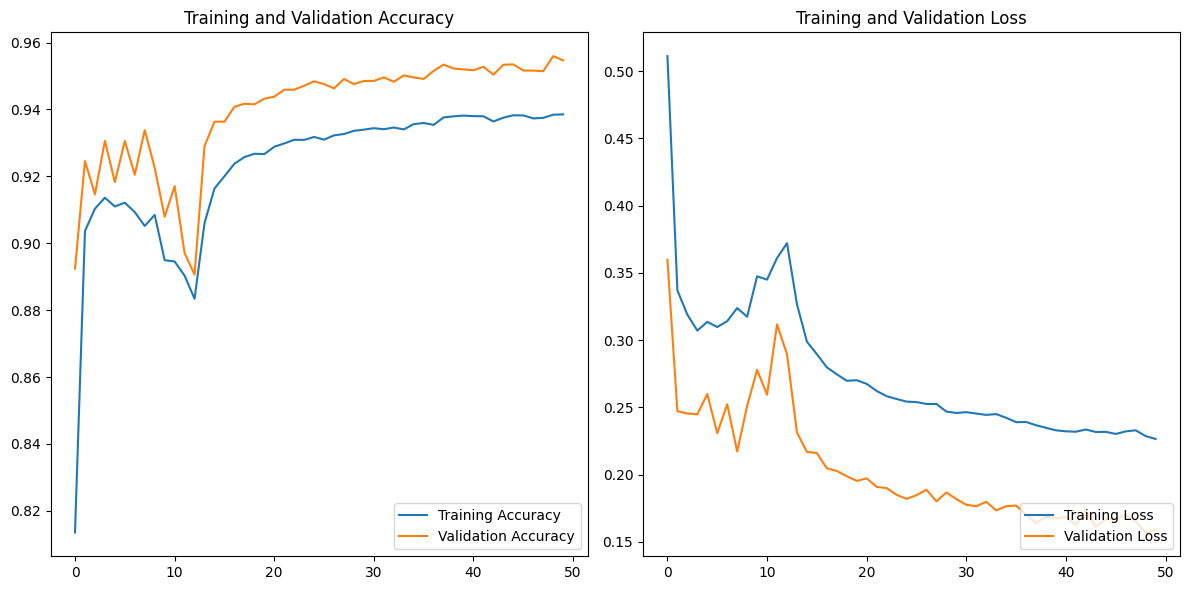

In [11]:
WINDOW_LENGTH = 20
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)
from tensorflow.keras.layers import SimpleRNN, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

model_4 = Sequential([
    SimpleRNN(128, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True),
    Dropout(0.5),
    SimpleRNN(64, activation='tanh', return_sequences=False),
    Dropout(0.5),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_4.summary()

model_4.save('../models/model_4/model_4_h10.keras')

start_time = time.time()

history_10 = model_4.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_4/history_10.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_10.history, file)


loss, accuracy = model_4.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_10)

---

### **Janela Temporal = 30**

In [11]:
WINDOW_LENGTH = 30
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)
from tensorflow.keras.layers import SimpleRNN, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

model_4 = Sequential([
    SimpleRNN(128, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True),
    Dropout(0.5),
    SimpleRNN(64, activation='tanh', return_sequences=False),
    Dropout(0.5),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_4.summary()

model_4.save('../models/model_4/model_4_h11.keras')

start_time = time.time()

history_11 = model_4.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_4/history_11.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_11.history, file)


loss, accuracy = model_4.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_11)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 20, 128)        │        18,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,123 (121.57 KB)

 Trainable params: 31,103 (121.50 KB)

 Non-trainable params: 20 (80.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 62s 6ms/step - accuracy: 0.7694 - loss: 0.6206 - val_accuracy: 0.9155 - val_loss: 0.2709 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 65s 6ms/step - accuracy: 0.9038 - loss: 0.3405 - val_accuracy: 0.9065 - val_loss: 0.3052 - learning_rate: 0.0010
Epoch 3/50
  769/10584 ━━━━━━━━━━━━━━━━━━━━ 50s 5ms/step - accuracy: 0.9140 - loss: 0.3111

KeyboardInterrupt: 

<h2 style="background-color:#C2B4B9; color:white; text-align:center; padding-top:5px; padding-bottom:5px; border-radius: 5px 5px;"><strong><centre>Modelo 5</centre></strong></h2>

### **Janela Temporal = 20**

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)        │ (None, 20, 128)        │        18,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │         6,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,603 (146.89 KB)

 Trainable params: 37,403 (146.11 KB)

 Non-trainable params: 200 (800.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 66s 6ms/step - accuracy: 0.5903 - loss: 0.8700 - val_accuracy: 0.7596 - val_loss: 0.5316 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 61s 6ms/step - accuracy: 0.7295 - loss: 0.5998 - val_accuracy: 0.7297 - val_loss: 0.5655 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 60s 6ms/step - accuracy: 0.6868 - loss: 0.6741 - val_accuracy: 0.7098 - val_loss: 0.5983 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 86s 8ms/step - accuracy: 0.7234 - loss: 0.6224 - val_accuracy: 0.6612 - val_loss: 0.6815 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 60s 6ms/step - accuracy: 0.6611 - loss: 0.6984 - val_accuracy: 0.5972 - val_loss: 0.8743 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 59s 6ms/step - accuracy: 0.6440 - loss: 0.7272 - val_accuracy: 0.6998 - val_loss: 0.5893 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 130s 12ms/step

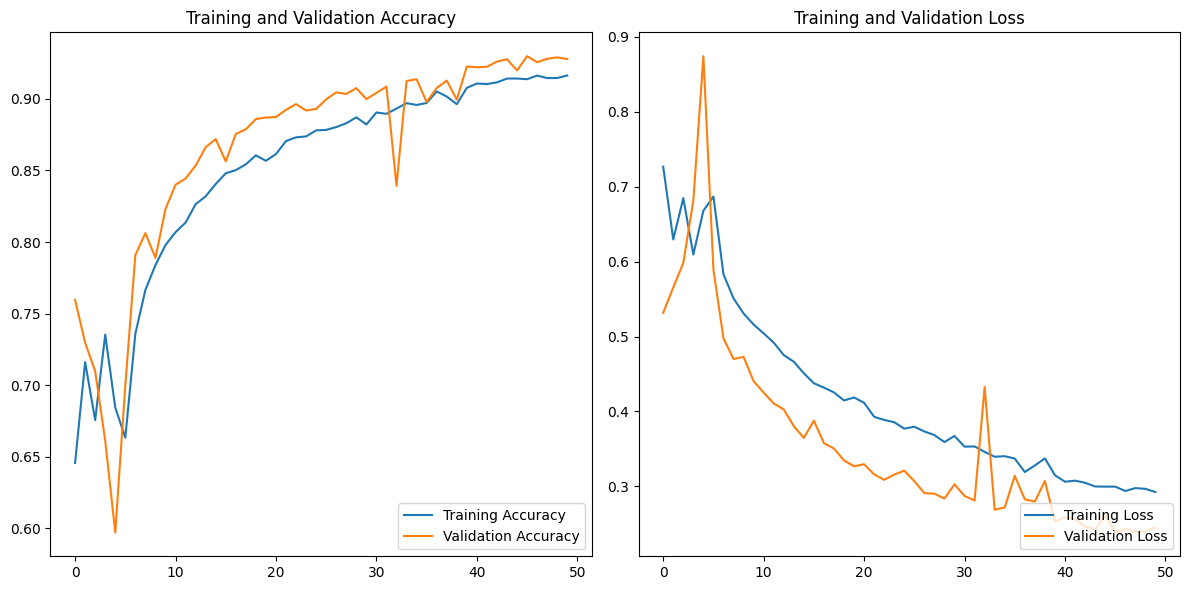

In [20]:
WINDOW_LENGTH = 20
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)
from tensorflow.keras.layers import SimpleRNN, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

model_5 = Sequential([
    SimpleRNN(128, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True),
    Dropout(0.5),
    SimpleRNN(64, activation='tanh', return_sequences=False),
    Dropout(0.5),
    Flatten(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])


model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_5.summary()

model_5.save('../models/model_5/model_5_h17.keras')

start_time = time.time()

history_17 = model_5.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_5/history_17.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_17.history, file)


loss, accuracy = model_5.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_17)

---

### **Janela Temporal = 30**

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_8 (SimpleRNN)        │ (None, 30, 128)        │        18,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │         6,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,603 (146.89 KB)

 Trainable params: 37,403 (146.11 KB)

 Non-trainable params: 200 (800.00 B)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 111s 10ms/step - accuracy: 0.5449 - loss: 0.9346 - val_accuracy: 0.5596 - val_loss: 0.9049 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 93s 9ms/step - accuracy: 0.4971 - loss: 0.9807 - val_accuracy: 0.6015 - val_loss: 0.8386 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 91s 9ms/step - accuracy: 0.5858 - loss: 0.8675 - val_accuracy: 0.6893 - val_loss: 0.6195 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 94s 9ms/step - accuracy: 0.6730 - loss: 0.6570 - val_accuracy: 0.6990 - val_loss: 0.5694 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 107s 10ms/step - accuracy: 0.6646 - loss: 0.6582 - val_accuracy: 0.6643 - val_loss: 0.5998 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 98s 9ms/step - accuracy: 0.6529 - loss: 0.6531 - val_accuracy: 0.6672 - val_loss: 0.5976 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 93s 9ms/st

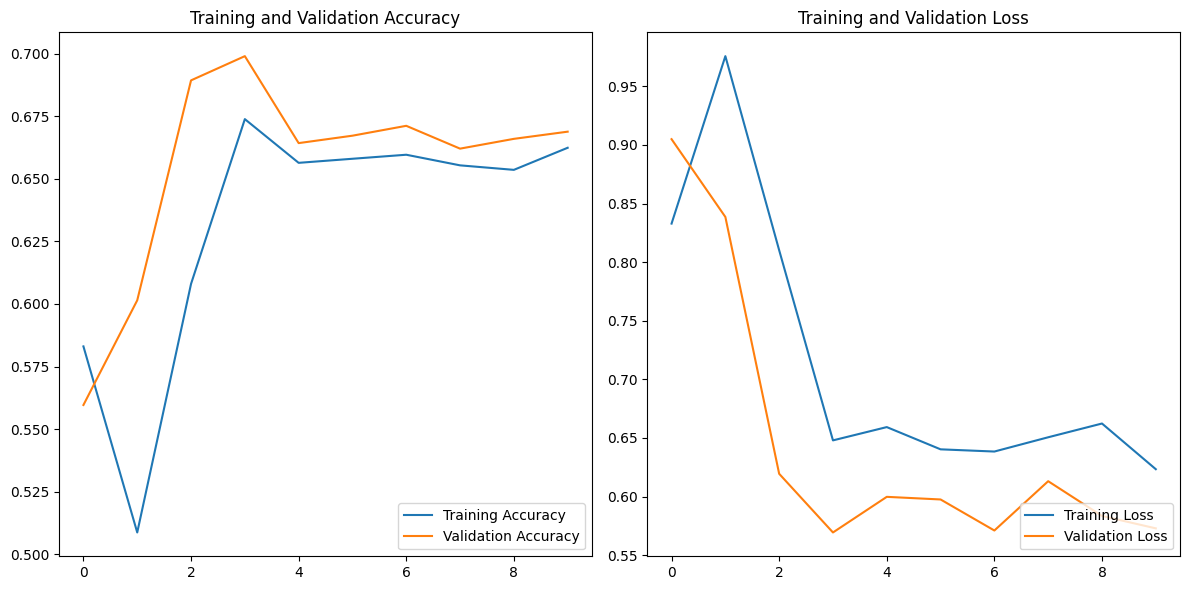

In [21]:
WINDOW_LENGTH = 30
    
X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)
from tensorflow.keras.layers import SimpleRNN, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

model_5 = Sequential([
    SimpleRNN(128, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True),
    Dropout(0.5),
    SimpleRNN(64, activation='tanh', return_sequences=False),
    Dropout(0.5),
    Flatten(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])


model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_5.summary()

model_5.save('../models/model_5/model_5_h14.keras')

start_time = time.time()

history_14 = model_5.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")

history_path = '../models/model_5/history_14.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history_14.history, file)


loss, accuracy = model_5.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history_14)

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_15 (SimpleRNN)       │ (None, 20, 100)        │        11,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 20, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 20, 100)        │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_16 (SimpleRNN)       │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,503 (126.96 KB)

 Trainable params: 32,103 (125.40 KB)

 Non-trainable params: 400 (1.56 KB)

Epoch 1/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 72s 7ms/step - accuracy: 0.8514 - loss: 0.4067 - val_accuracy: 0.9414 - val_loss: 0.1939 - learning_rate: 0.0010
Epoch 2/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 171s 16ms/step - accuracy: 0.9305 - loss: 0.2339 - val_accuracy: 0.9431 - val_loss: 0.1906 - learning_rate: 0.0010
Epoch 3/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 61s 6ms/step - accuracy: 0.9360 - loss: 0.2153 - val_accuracy: 0.9462 - val_loss: 0.1816 - learning_rate: 0.0010
Epoch 4/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 64s 6ms/step - accuracy: 0.9396 - loss: 0.2049 - val_accuracy: 0.9453 - val_loss: 0.1796 - learning_rate: 0.0010
Epoch 5/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 60s 6ms/step - accuracy: 0.9389 - loss: 0.2050 - val_accuracy: 0.9525 - val_loss: 0.1622 - learning_rate: 0.0010
Epoch 6/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 102s 10ms/step - accuracy: 0.9405 - loss: 0.2003 - val_accuracy: 0.9539 - val_loss: 0.1582 - learning_rate: 0.0010
Epoch 7/50
10584/10584 ━━━━━━━━━━━━━━━━━━━━ 74s 7ms/st

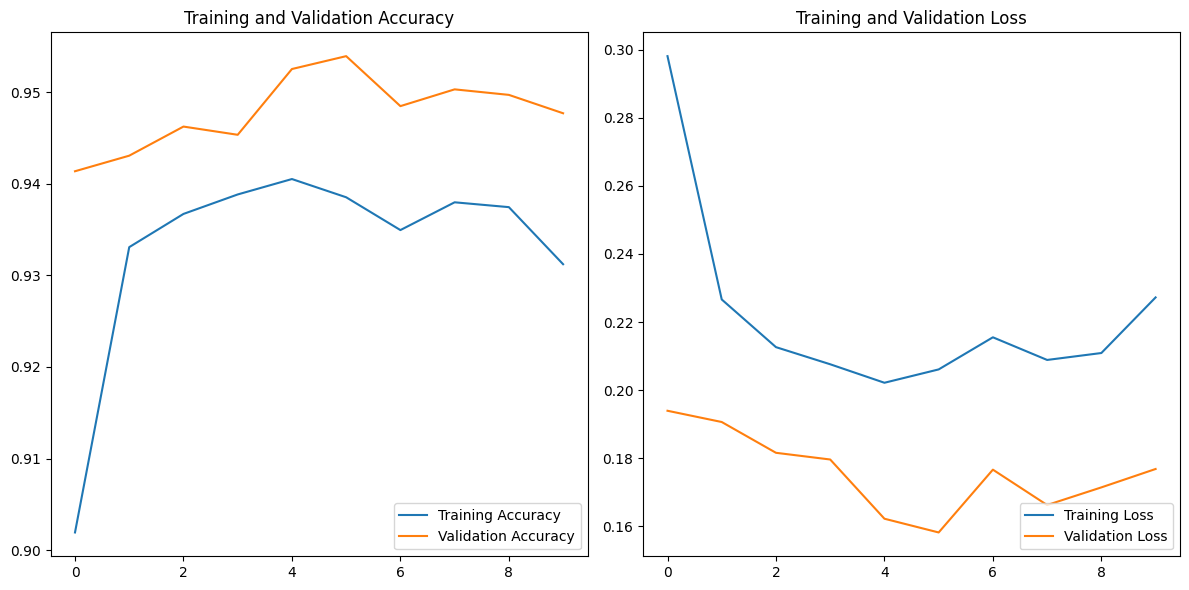

In [ ]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout, BatchNormalization

WINDOW_LENGTH = 20

X_train, X_test, y_train, y_test = prepare_data(df_motionSense, WINDOW_LENGTH)

# Crie o modelo
model = Sequential([
    SimpleRNN(100, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True),
    Dropout(0.2),
    BatchNormalization(),
    SimpleRNN(100, activation='tanh', return_sequences=False),
    Dropout(0.5),
    BatchNormalization(),
    Dense(NUM_CLASSES, activation='softmax')
])

# Adicione uma camada RNN com 64 unidades e Dropout
#model.add(SimpleRNN(64, activation='tanh', input_shape=(WINDOW_LENGTH, NUM_FEATURES), return_sequences=True))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())

# Adicione uma segunda camada RNN com 32 unidades e Dropout
#model.add(SimpleRNN(32, activation='tanh', return_sequences=False))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())

# Adicione uma camada densa para a saída com ativação softmax
#model.add(Dense(NUM_CLASSES, activation='softmax'))

# Compile o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

#model_4.save('../models/model_4/model_4_h2.h5')
#model_4.save('../models/model_4/model_4_h2.keras')

#start_time = time.time()

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

#end_time = time.time()
#execution_time = end_time - start_time
#print(f"Tempo de execução: {execution_time} segundos")

#history_path = '../models/model_4/history_2.pkl'
#with open(history_path, 'wb') as file:
 #   pickle.dump(history_2.history, file)


loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

plot_training_results(history)

In [ ]:
model = Sequential()
# Adicione a primeira camada SimpleRNN com dropout
model.add(SimpleRNN(units=50, return_sequences=True, activation='tahn'))
model.add(Dropout(0.5))

# Adicione a segunda camada SimpleRNN com dropout
model.add(SimpleRNN(units=50))
model.add(Dropout(0.5))

# Adicione a camada densa para classificação
model.add(Dense(units=3, activation='softmax'))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 20, 50)         │         3,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,353 (32.63 KB)

 Trainable params: 8,353 (32.63 KB)

 Non-trainable params: 0 (0.00 B)